In [1]:
import glob
import pandas as pd
import os

%matplotlib inline

In [2]:
def feature_counts(directory):
    fn = directory+ '/feature_names.txt'
    with open(fn) as f:
        lines = f.readlines()
        keep = int(lines[1].split('\t')[1])
        remove = int(lines[2].split('\t')[1])
    return keep, remove

In [3]:
def load_majority_vote(exp_path):
    fn = exp_path+'/majority_vote.csv'
    res = pd.read_csv(fn)
    return res

def load_roadnet(exp_path):
    fselects = ['None']
    res = []
    for selection_type in fselects:
        exp_param_path = '%s/%s#%s' %(exp_path, 'RoadNet', selection_type)
        fn = '%s/cv_5_best_models_evaluation.csv' %(exp_param_path)
        cv_res = pd.read_csv(fn)
        cv_res.columns = ['kind', 'model'] + cv_res.columns[2:].tolist()
        cv_res['feature_select'] = selection_type
        cv_res['scale'] = 'min-max'
        cv_res['feature'] = 'RoadNet'
        keep, remove = feature_counts(exp_param_path)
        cv_res['# ftr keep'] = keep
        cv_res['# ftr remove'] = remove
        res.append(cv_res)
    res = pd.concat(res)
    return res 

def load_else(exp_path):
    
    totals = ['NO_TOTAL', 'TOTAL']
    years_choices = ['~2014']
    feature_types = ['Segment', 'RoadNet+Segment']
    res = []
    for total_or_not in totals:
        for year in years_choices:
            for ftr_type in feature_types:
                for max_cut in ( False,):
                    for selection_type in ['None']:
                        scale_type = 'max-cutoff' if max_cut else 'min-max'
                        exp_param = '#'.join([ftr_type, total_or_not, year, scale_type, selection_type])
                        fn = '%s/%s/cv_5_best_models_evaluation.csv' % (exp_path, exp_param)
                        cv_res = pd.read_csv(fn)
                        cv_res.columns = ['kind', 'model'] + cv_res.columns[2:].tolist()
                        cv_res['feature_select'] = selection_type
                        cv_res['scale'] = scale_type
                        cv_res['feature'] = ftr_type
                        cv_res['time period'] = year
                        cv_res['total or by type'] = total_or_not
                        keep, remove = feature_counts('%s/%s' % (exp_path, exp_param))
                        cv_res['# ftr keep'] = keep
                        cv_res['# ftr remove'] = remove
                        res.append(cv_res)
    res = pd.concat(res)

    return res 

def load_one_run(seed,weight_name):
    exp_path = 'experiment_1001/exp1_amp/%s/seed_%d' % (weight_name, seed)
    major = load_majority_vote(exp_path)
    roadnet = load_roadnet(exp_path)
    res_else = load_else(exp_path)
    res = pd.concat([major, roadnet, res_else], ignore_index=True)
    res['seed'] = seed
    res['weight_name'] = weight_name
    return res

def load_all_run(weight_name):
    all_run = []
    for seed in [0, 100, 972, 5258, 7821, 40918, 57852, 168352, 291592, 789729423]:
        one_run_res = load_one_run(seed, weight_name)
        all_run.append(one_run_res)
    all_run_res = pd.concat(all_run, ignore_index=True)
    all_run_res.fillna('', inplace=True)
    all_run_res['key'] = all_run_res.apply(lambda x: '%s %s %s %s %s %s'.strip() % (x['feature'], x['total or by type'], x['time period'], x['model'], x['scale'], x['feature_select']), axis=1)        
#     all_run_res['key'] = all_run_res.apply(lambda x: '%s %s %s %s'.strip() % (x['feature'], x['total or by type'], x['model'], x['scale']), axis=1)        
    return all_run_res

In [4]:
def get_all_res():
    all_res = {}
    for weight_name in ['amplify_fcir', 'amplify_fr']:
        res = load_all_run(weight_name)
        res['col_name'] = res.apply(lambda x: x['feature']+' '+x['total or by type'],axis=1)
        all_res[weight_name] = res
    return all_res

In [5]:
all_res = get_all_res()

Drop useless columns

In [6]:
def clean_res(res):
    col_mapping = {' ': ' ',
     'RoadNet ': 'RoadNet',
     'Segment NO_TOTAL': 'Social type', 
     'RoadNet+Segment NO_TOTAL': 'RoadNet+Social type',
     'Segment TOTAL': 'Social total', 
     'RoadNet+Segment TOTAL': 'RoadNet+Social total'}
    clean_res = res.drop(['feature', 'total or by type', 'time period', 'scale', 'feature_select',
                      'kind', '# ftr remove', '# ftr keep', 
                      'train_acc', 'train_f1_macro', 'train_f1_micro', 'train_f1_weighted', 'train_mse',
                      'test_acc', 'test_mse',
                      'seed',
                      'key',
                     ], axis=1)
    clean_res.col_name = clean_res.col_name.apply(lambda x: col_mapping[x])
    return clean_res

def get_clean_mean_std(all_res):
    all_clean_res = {}
    all_means = {}
    all_stds = {}
    for weight_name, res in all_res.items():
        c_res = clean_res(res)
        all_clean_res[weight_name] = c_res
        means = c_res.groupby(['col_name', 'model']).mean()
        all_means[weight_name] = means
        stds = c_res.groupby(['col_name', 'model']).std()
        all_stds[weight_name] = stds
    return all_clean_res, all_means, all_stds


In [7]:


all_clean_res, all_means, all_stds = get_clean_mean_std(all_res)

## produce dtb(deliverable table) for paper

In [8]:
def deliverable_table(table):
    table.loc['majority_vote'] = table.loc['majority_vote', ' ']
    table.drop(' ', axis=1, inplace=True)
#     table.columns = ['RoadNet', 'RoadNet+Social type', 'RoadNet+Social total', 'Social type', 'Social total']
    table = table[['RoadNet', 'Social total', 'Social type', 'RoadNet+Social total', 'RoadNet+Social type']]
    table = table.loc[['majority_vote', 'ols', 'lasso', 'ridge', 'logistics', 'linearSVM', 'linearSVR',
               'SVM', 'SVR', 'MLPcls', 'MLPreg', 'DTcls', 'DTreg', 'RFcls', 'RFreg',
               'ADAcls', 'ADAreg', 'BAGcls', 'BAGreg', 'GDBcls', 'GDBreg', 'XGBcls', 'XGBreg',
          ]]
    return table

In [9]:
f1_choices = [ 'test_f1_micro', 'test_f1_macro', 'test_f1_weighted']
for weight_name, means in all_means.items():
    for f1_type in f1_choices:    
        table = means.reset_index().pivot(index='model', columns='col_name', values=f1_type)
        dtb = deliverable_table(table)
#         dtb.to_csv('deliverables/experiment_1001/EXP1 %s %s.csv' % (weight_name, f1_type))


## error bar of top N solution

In [10]:
from IPython.display import display

In [11]:
WEIGHT_NAMES = ['amplify_fcir', 'amplify_fr']

In [12]:
max_res = []

for weight_name in WEIGHT_NAMES:
#     print(mapping[weight_name])
    for f1_type in f1_choices:
        means_to_plot = all_means[weight_name].sort_values(f1_type, ascending=False).head(3)
        index_to_plot = means_to_plot.index
        str_to_print = '; '.join(['%s %s %.3f' % (f, m, f1) for (f, m), f1 in means_to_plot[f1_type].iteritems()])
#         print(f1_type+': ', str_to_print)

        max_ = means_to_plot[f1_type].values[0]    
        max_res.append({'f1_type': f1_type, 'name': weight_name, 'max_':max_, 'str': str_to_print})

In [13]:
df = pd.DataFrame(max_res)
df_micro = df[df.f1_type=='test_f1_micro']
df_macro = df[df.f1_type=='test_f1_macro']
df_w = df[df.f1_type=='test_f1_weighted']

In [17]:
def formating(x):
    return ','.join(['"'+x['name']+'"'] + x['str'].split(';')[0].rsplit(' ', 2))

In [18]:
df_micro.sort_values('max_', ascending=False)
print('\n'.join(df_micro.sort_values('max_', ascending=False).apply(formating, axis=1)))

"amplify_fr",RoadNet+Social total,GDBreg,0.616
"amplify_fcir",RoadNet+Social type,RFcls,0.521


In [19]:
df_macro.sort_values('max_', ascending=False)
print('\n'.join(df_macro.sort_values('max_', ascending=False).apply(formating, axis=1)))

"amplify_fcir",RoadNet,GDBcls,0.485
"amplify_fr",RoadNet+Social type,BAGcls,0.481


In [22]:
df_w.sort_values('max_', ascending=False)

,f1_type,max_,name,str
5,test_f1_weighted,0.592161,amplify_fr,RoadNet+Social total GDBcls 0.592; RoadNet+Soc...
2,test_f1_weighted,0.510747,amplify_fcir,RoadNet GDBcls 0.511; RoadNet+Social total GDB...


amplify_fr test_f1_micro:  RoadNet+Social total GDBreg 0.616; RoadNet+Social total GDBcls 0.616; RoadNet+Social total BAGreg 0.613


test_f1_macro  test_f1_micro  test_f1_weighted
col_name             model                                                 
RoadNet+Social total GDBreg       0.391366       0.615730          0.587495
                     GDBcls       0.459724       0.615730          0.592161
                     BAGreg       0.349101       0.613483          0.577723

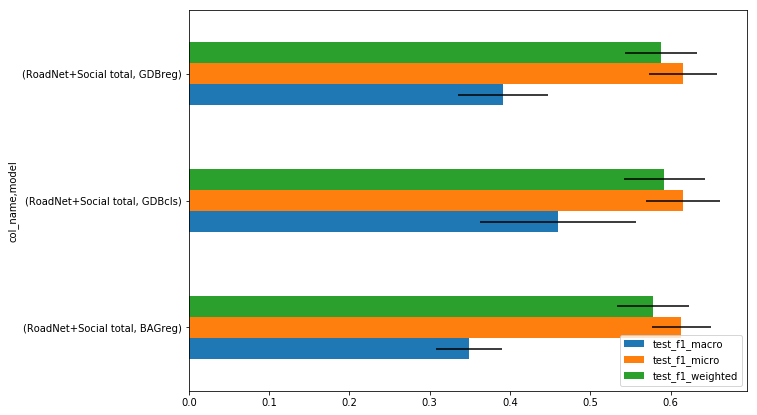

In [17]:
f1_type=f1_choices[0]
weight_name = weight_names[1]
means_to_plot = all_means[weight_name].sort_values(f1_type, ascending=False).head(3)
index_to_plot = means_to_plot.index
stds_to_plot = all_stds[weight_name].loc[index_to_plot]

print(weight_name, f1_type+': ', '; '.join(['%s %s %.3f' % (f, m, f1) for (f, m), f1 in means_to_plot[f1_type].iteritems()]))

display(means_to_plot)
means_to_plot.sort_values(f1_type).plot(kind='barh', xerr=stds_to_plot, figsize=(10,7))